<a href="https://colab.research.google.com/github/Sankytanky100/Data-Engineering/blob/main/Healthcare_Data_Engineering_with_PostgreSQL_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective: Develop a healthcare data management system to store, manage, and analyze patient and hospital data.**

Technologies Used:
PostgreSQL for database management.

Python for data processing and interaction with the database.

Google Colab as the development environment.


In [22]:
# Install PostgreSQL
!apt-get install postgresql postgresql-contrib -y

# Start the PostgreSQL service
!service postgresql start

# Set the password for the 'postgres' user
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'postgres';"

# Create a new database called 'healthcare_db'
!sudo -u postgres createdb healthcare_db


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
postgresql is already the newest version (14+238).
postgresql-contrib is already the newest version (14+238).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
 * Starting PostgreSQL 14 database server
   ...done.
ALTER ROLE
createdb: error: database creation failed: ERROR:  database "healthcare_db" already exists


In [23]:
# Install psycopg2 to connect to PostgreSQL
!pip install psycopg2-binary

# Import libraries
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [24]:
# Function to create a connection
def create_connection():
    conn = psycopg2.connect(
        database="healthcare_db",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5432"
    )
    return conn



# Test the connection
conn = create_connection()
cursor = conn.cursor()
print("Connection established:", conn)


Connection established: <connection object at 0x7826ea7dd6c0; dsn: 'user=postgres password=xxx dbname=healthcare_db host=localhost port=5432', closed: 0>


In [25]:
# Load the dataset into a pandas DataFrame
hospital_df = pd.read_csv('hospital_general_info.csv')
hospital_df.head()


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN


In [26]:
# Connect to the database
conn = create_connection()
cursor = conn.cursor()

# Create Hospitals table
create_hospitals_table = """
CREATE TABLE IF NOT EXISTS hospitals (
    hospital_id SERIAL PRIMARY KEY,
    name VARCHAR(255),
    address VARCHAR(255),
    city VARCHAR(100),
    state VARCHAR(2),
    zip_code VARCHAR(10),
    county_name VARCHAR(100),
    phone_number VARCHAR(20),
    hospital_type VARCHAR(100),
    hospital_ownership VARCHAR(100),
    emergency_services VARCHAR(10)
);
"""

# Create Patients table
create_patients_table = """
CREATE TABLE IF NOT EXISTS patients (
    patient_id SERIAL PRIMARY KEY,
    first_name VARCHAR(100),
    last_name VARCHAR(100),
    date_of_birth DATE,
    gender VARCHAR(10),
    address VARCHAR(255),
    city VARCHAR(100),
    state VARCHAR(2),
    zip_code VARCHAR(10),
    phone_number VARCHAR(20),
    hospital_id INTEGER REFERENCES hospitals(hospital_id)
);
"""

# Execute the table creation queries
cursor.execute(create_hospitals_table)
cursor.execute(create_patients_table)
conn.commit()
print("Tables created successfully.")


Tables created successfully.


In [27]:
# Select and rename relevant columns
hospital_df = hospital_df.rename(columns={
    'Facility ID': 'facility_id',
    'Facility Name': 'name',
    'Address': 'address',
    'City/Town': 'city',
    'State': 'state',
    'ZIP Code': 'zip_code',
    'County/Parish': 'county_name',
    'Telephone Number': 'phone_number',
    'Hospital Type': 'hospital_type',
    'Hospital Ownership': 'hospital_ownership',
    'Emergency Services': 'emergency_services'
})

# Keep only necessary columns
hospital_df = hospital_df[[
    'name', 'address', 'city', 'state', 'zip_code',
    'county_name', 'phone_number', 'hospital_type',
    'hospital_ownership', 'emergency_services'
]]

# Handle missing values
hospital_df = hospital_df.fillna('Unknown')

hospital_df.head()


,name,address,city,state,zip_code,county_name,phone_number,hospital_type,hospital_ownership,emergency_services
0,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,Yes
1,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,Yes
2,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,Yes
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,Yes
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,Yes


In [28]:
# Create the stored procedure
create_procedure_query = """
CREATE OR REPLACE PROCEDURE insert_patient(
    p_first_name VARCHAR,
    p_last_name VARCHAR,
    p_date_of_birth DATE,
    p_gender VARCHAR,
    p_address VARCHAR,
    p_city VARCHAR,
    p_state VARCHAR,
    p_zip_code VARCHAR,
    p_phone_number VARCHAR,
    p_hospital_id INTEGER
)
LANGUAGE plpgsql
AS $$
BEGIN
    INSERT INTO patients (
        first_name, last_name, date_of_birth, gender,
        address, city, state, zip_code, phone_number, hospital_id
    ) VALUES (
        p_first_name, p_last_name, p_date_of_birth, p_gender,
        p_address, p_city, p_state, p_zip_code, p_phone_number, p_hospital_id
    );
END;
$$;
"""

cursor.execute(create_procedure_query)
conn.commit()
print("Stored procedure 'insert_patient' created successfully.")


Stored procedure 'insert_patient' created successfully.


In [29]:
# Create the function
create_function_query = """
CREATE OR REPLACE FUNCTION calculate_age(p_date_of_birth DATE)
RETURNS INTEGER AS $$
BEGIN
    RETURN DATE_PART('year', AGE(p_date_of_birth));
END;
$$ LANGUAGE plpgsql;
"""

cursor.execute(create_function_query)
conn.commit()
print("Function 'calculate_age' created successfully.")


Function 'calculate_age' created successfully.


In [30]:
# Function to insert patient data using the stored procedure
def insert_patient_data(df, conn):
    cursor = conn.cursor()
    for index, row in df.iterrows():
        cursor.callproc('insert_patient', [
            row['first_name'], row['last_name'], row['date_of_birth'], row['gender'],
            row['address'], row['city'], row['state'], row['zip_code'],
            row['phone_number'], row['hospital_id']
        ])
    conn.commit()
    print("Patient data inserted successfully using stored procedure.")

In [31]:
# Generate synthetic patient data
num_patients = 1000
patient_data = {
    'first_name': np.random.choice(['John', 'Jane', 'Alice', 'Bob', 'Carol'], num_patients),
    'last_name': np.random.choice(['Smith', 'Doe', 'Johnson', 'Lee', 'Brown'], num_patients),
    'date_of_birth': pd.to_datetime(np.random.randint(0, 20000, num_patients), unit='D', origin='1960-01-01'),
    'gender': np.random.choice(['Male', 'Female'], num_patients),
    'address': np.random.choice(['123 Main St', '456 Elm St', '789 Oak St'], num_patients),
    'city': np.random.choice(['New York', 'Los Angeles', 'Chicago'], num_patients),
    'state': np.random.choice(['NY', 'CA', 'IL'], num_patients),
    'zip_code': np.random.choice(['10001', '90001', '60601'], num_patients),
    'phone_number': np.random.choice(['555-1234', '555-5678', '555-9012'], num_patients),
    'hospital_id': np.random.randint(1, len(hospital_df)+1, num_patients)
}

patient_df = pd.DataFrame(patient_data)
patient_df.head()


,first_name,last_name,date_of_birth,gender,address,city,state,zip_code,phone_number,hospital_id
0,Alice,Lee,1996-03-27,Male,123 Main St,Los Angeles,IL,90001,555-5678,3512
1,Carol,Lee,2007-09-17,Male,456 Elm St,New York,IL,60601,555-9012,2503
2,Jane,Smith,2006-08-14,Male,456 Elm St,Los Angeles,NY,90001,555-5678,906
3,Jane,Doe,1980-03-03,Male,456 Elm St,Los Angeles,CA,90001,555-9012,4587
4,Jane,Johnson,1981-05-12,Female,123 Main St,Chicago,IL,10001,555-5678,4150


In [32]:
# Function to insert patient data
def insert_patient_data(df, conn):
    cursor = conn.cursor()
    for index, row in df.iterrows():
        insert_query = """
        INSERT INTO patients (
            first_name, last_name, date_of_birth, gender,
            address, city, state, zip_code, phone_number, hospital_id
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """
        data_tuple = (
            row['first_name'], row['last_name'], row['date_of_birth'], row['gender'],
            row['address'], row['city'], row['state'], row['zip_code'],
            row['phone_number'], row['hospital_id']
        )
        cursor.execute(insert_query, data_tuple)
    conn.commit()
    print("Patient data inserted successfully.")

# Insert data
insert_patient_data(patient_df, conn)


Patient data inserted successfully.


In [33]:
# Example query to get patient names and ages
query = """
SELECT first_name, last_name, calculate_age(date_of_birth) AS age
FROM patients
LIMIT 10;
"""

patient_ages = pd.read_sql_query(query, conn)
patient_ages


<ipython-input-33-8fc4902c8260>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  patient_ages = pd.read_sql_query(query, conn)


,first_name,last_name,age
0,Carol,Smith,36
1,Bob,Brown,14
2,Jane,Brown,49
3,John,Lee,27
4,Jane,Johnson,43
5,Carol,Doe,38
6,Alice,Doe,16
7,John,Smith,37
8,Carol,Lee,31
9,Alice,Johnson,25


In [34]:
query = """
SELECT h.name, COUNT(p.patient_id) as patient_count
FROM hospitals h
JOIN patients p ON h.hospital_id = p.hospital_id
GROUP BY h.name
ORDER BY patient_count DESC
LIMIT 10;
"""

patient_counts = pd.read_sql_query(query, conn)
patient_counts


<ipython-input-34-8d96a2c6eefd>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  patient_counts = pd.read_sql_query(query, conn)


,name,patient_count
0,MEMORIAL HOSPITAL,6
1,NEW YORK-PRESBYTERIAN HOSPITAL,5
2,COMMUNITY MEMORIAL HOSPITAL,4
3,ST JOSEPH MEDICAL CENTER,4
4,"HOSPITAL MENONITA HUMACAO, INC",4
5,UNITY MEDICAL CENTER,3
6,UP HEALTH SYSTEM PORTAGE,3
7,BAYLOR SCOTT AND WHITE EMERGENCY HOSPITAL,3
8,CORNING HOSPITAL,3
9,KETTERING HEALTH GREENE MEMORIAL,3


In [35]:
query = """
SELECT state, COUNT(patient_id) as patient_count
FROM patients
GROUP BY state;
"""

state_distribution = pd.read_sql_query(query, conn)
state_distribution


<ipython-input-35-d72a14f311a7>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  state_distribution = pd.read_sql_query(query, conn)


,state,patient_count
0,CA,656
1,IL,680
2,NY,664


**Data Pipeline Automation**

In [36]:
def extract_data(url, filename):
    try:
        !wget -O {filename} "{url}"
        print(f"Data extracted and saved as {filename}.")
    except Exception as e:
        print(f"Error extracting data: {e}")

def transform_hospital_data(filename):
    df = pd.read_csv(filename)
    df = df.rename(columns={
        'Facility ID': 'facility_id',
        'Facility Name': 'name',
        'Address': 'address',
        'City': 'city',
        'State': 'state',
        'ZIP Code': 'zip_code',
        'County Name': 'county_name',
        'Phone Number': 'phone_number',
        'Hospital Type': 'hospital_type',
        'Hospital Ownership': 'hospital_ownership',
        'Emergency Services': 'emergency_services'
    })
    df = df[[
        'name', 'address', 'city', 'state', 'zip_code',
        'county_name', 'phone_number', 'hospital_type',
        'hospital_ownership', 'emergency_services'
    ]]
    df = df.fillna('Unknown')
    print("Hospital data transformed.")
    return df


**Data Analysis Using Stored Functions**

In [56]:
create_avg_age_function = """
CREATE OR REPLACE FUNCTION avg_patient_age(p_hospital_id INTEGER)
RETURNS FLOAT AS $$
DECLARE
    avg_age FLOAT;
BEGIN
    SELECT AVG(calculate_age(date_of_birth)) INTO avg_age
    FROM patients
    WHERE hospital_id = p_hospital_id;
    RETURN avg_age;
END;
$$ LANGUAGE plpgsql;
"""

cursor.execute(create_avg_age_function)
conn.commit()
print("Function 'avg_patient_age' created successfully.")


Function 'avg_patient_age' created successfully.


In [57]:
# Query to get hospital names and average patient ages
query = """
SELECT h.name, avg_patient_age(h.hospital_id) AS average_age
FROM hospitals h
JOIN patients p ON h.hospital_id = p.hospital_id
GROUP BY h.name, h.hospital_id
ORDER BY average_age DESC
LIMIT 10;
"""

avg_ages = pd.read_sql_query(query, conn)
avg_ages


<ipython-input-57-2c6f1ef16fbc>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  avg_ages = pd.read_sql_query(query, conn)


,name,average_age
0,UNION HOSPITAL CLINTON,64.0
1,ASPIRUS RIVERVIEW HOSPITAL & CLINICS INC,64.0
2,GREENE COUNTY GENERAL HOSPITAL,64.0
3,THE JAMES B. HAGGIN MEMORIAL HOSPITAL,64.0
4,OSS ORTHOPAEDIC HOSPITAL,64.0
5,HOSPITAL UNIVERSITARIO DR RUIZ ARNAU,64.0
6,ASCENSION SE WISCONSIN HOSPITAL,64.0
7,HCA FLORIDA FORT WALTON-DESTIN HOSPITAL,64.0
8,PIH HEALTH DOWNEY HOSPITAL,64.0
9,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,64.0


**Data Visualization**

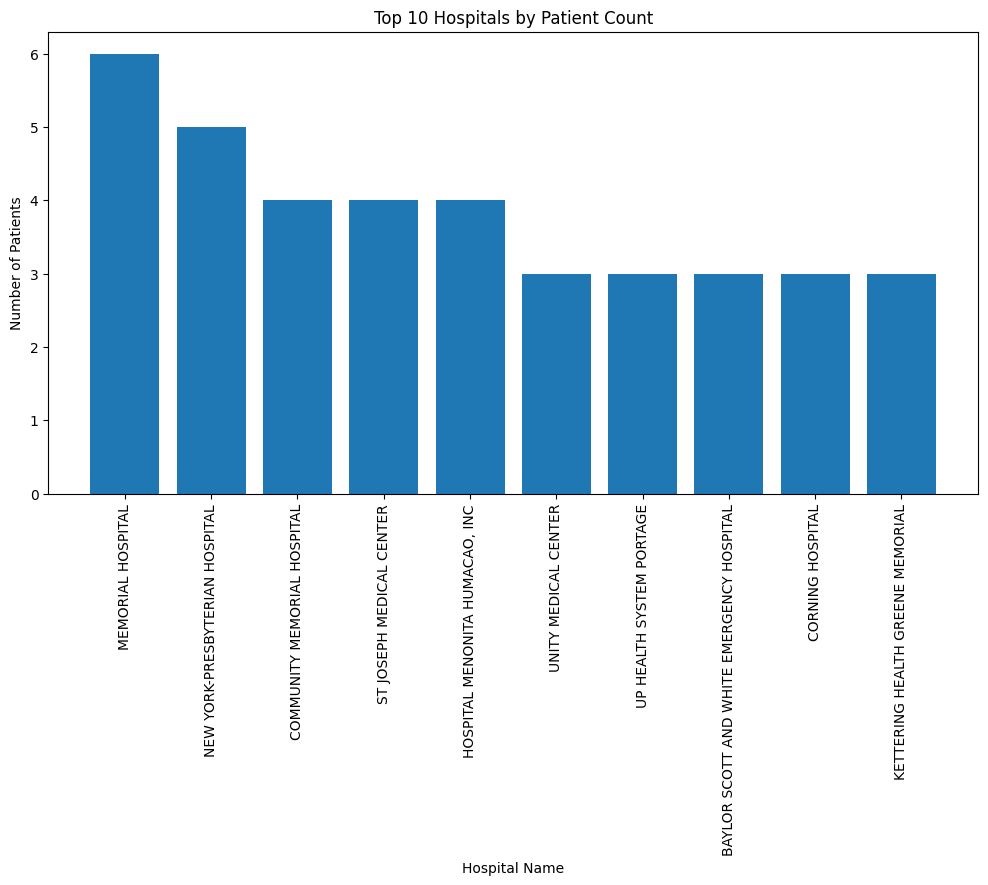

In [58]:
# Bar chart of patients per hospital
plt.figure(figsize=(12,6))
plt.bar(patient_counts['name'], patient_counts['patient_count'])
plt.xticks(rotation=90)
plt.xlabel('Hospital Name')
plt.ylabel('Number of Patients')
plt.title('Top 10 Hospitals by Patient Count')
plt.show()


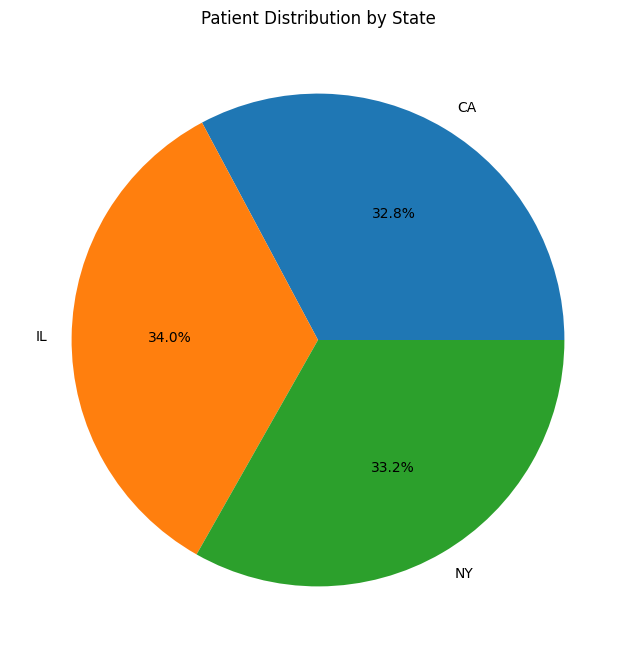

In [59]:
# Pie chart of patient distribution by state
plt.figure(figsize=(8,8))
plt.pie(state_distribution['patient_count'], labels=state_distribution['state'], autopct='%1.1f%%')
plt.title('Patient Distribution by State')
plt.show()


In [60]:
import os

# Create the directory if it doesn't exist
os.makedirs("./results/article_to_article_csv", exist_ok=True)

DataFrame_to_save = patient_counts  # or state_distribution

DataFrame_to_save.to_csv("./results/article_to_article_csv/data.csv", header=True, index=False)

print("DataFrame saved as CSV in './results/article_to_article_csv/data.csv'.")

DataFrame saved as CSV in './results/article_to_article_csv/data.csv'.
